In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

import pickle
import networkx as nx
from pyvis import network as net
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

# Task One

In [2]:
KYCPATH = Path('./data/raw/kyc.csv')
kyc = pd.read_csv(KYCPATH)

First, we can see that the data is heavily imbalanced, with only ~2% positive labels

In [10]:
kyc.groupby('label')['cust_id'].count()

label
0    190275
1      5514
Name: cust_id, dtype: int64

Breaking down the labels, we can see that age and tenure can discriminate between labels

label
0    35.670687
1    41.428908
Name: age, dtype: float64

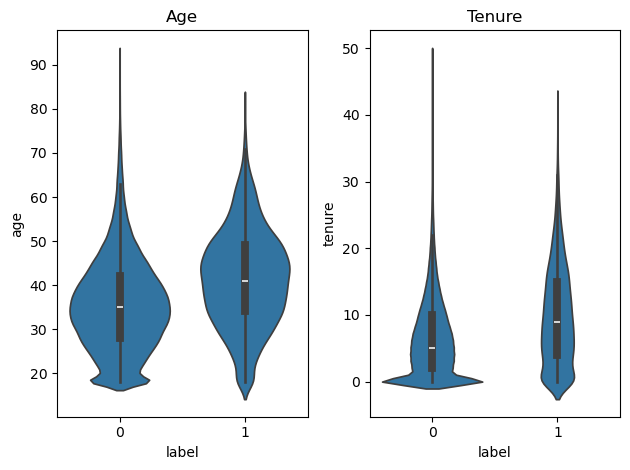

In [26]:
display(kyc.groupby('label')['age'].mean())

f,axs=plt.subplots(1,2)
sns.violinplot(x=kyc['label'], y=kyc['age'], ax=axs[0])
sns.violinplot(x=kyc['label'], y=kyc['tenure'], ax=axs[1])

axs[0].set_title('Age')
axs[1].set_title('Tenure')

plt.tight_layout()
plt.show()

Gender is less discriminating - there are no differences in male/female/other in positive vs negative labels.

In [26]:
pd.crosstab(kyc['label'], kyc['gender'], normalize='index')

gender,female,male,other
label,,,
0,0.450679,0.449718,0.099603
1,0.455205,0.446863,0.097933


There are 250 unique occupations in the KYC dataset. Of these, 22 of these have no positive labels

In [37]:
len(kyc.occupation.unique())

250

In [38]:
df = kyc.groupby('occupation', as_index=False)['label'].sum()
len(df[df.label==0])

22

The occupations with the most positive labels are `Other`, `Real Estate Broker`, and `Unemployed`. However, looking at the *frequency* of positive labels, the top occupations are `Import/Export Business Owner`, `Online Gambling Site Operator` and `Free Trade Zone Operator`. Clearly, occupation will have a significant impact on money laundering likelihood.

In [49]:
df = kyc.groupby('occupation', as_index=False)['label'].sum()
df.sort_values(by='label', ascending=False)

,occupation,label
164,Other,180
195,Real Estate Broker,178
233,Unemployed,167
32,Car Dealership Owner,161
91,"Freelancer (e.g., Graphic Designer, Writer)",149
...,...,...
69,Entomologist,0
107,Hydrologist,0
102,Herpetologist,0
147,Mycologist,0


In [50]:
df = kyc.groupby('occupation', as_index=False)['label'].mean()
df.sort_values(by='label', ascending=False)

,occupation,label
110,Import/Export Business Owner,0.423387
160,Online Gambling Site Operator,0.404762
90,Free Trade Zone Operator,0.401163
153,Notary Public,0.400000
55,Cryptocurrency Trader,0.398104
...,...,...
165,Paleontologist,0.000000
107,Hydrologist,0.000000
162,Ornithologist,0.000000
109,Illustrator,0.000000


In [48]:
df[df.occupation=='Real Estate Agent']

,occupation,label
194,Real Estate Agent,0.031877


## Additional KYC Eda

In [37]:
len(kyc[kyc.name.str.contains('DR.')])

24640

There are 24000 Doctors in the dataset. Let's take a closer look.

In [46]:
df = kyc.copy()
df['dr_flag'] = df['name'].map(lambda x: 1 if 'DR.' in x else 0)
df[df.dr_flag==1].sample(5)

,name,gender,occupation,age,tenure,cust_id,label,dr_flag
19330,DR.GARY ANDERSON,male,Import/Export Dealer,27.0,5.0,CUST65891146,0,1
12374,DR.DANIEL SMITH,male,Barista,22.0,0.0,CUST61625924,0,1
181298,DR.QIAO YAN,female,Factory Worker,37.0,7.0,CUST72697110,0,1
91822,DR.BRIAN JOHNSON,male,Call Center Representative,29.0,7.0,CUST26546581,0,1
9914,DR. SARAH CARTER,female,"Freelancer (e.g., Graphic Designer, Writer)",25.0,0.0,CUST18730175,0,1


A surprising number of them are not working in degree-appropriate fields... Maybe a PhD is a mistake.

In [48]:
pd.crosstab(df['label'], df['dr_flag'], normalize='index')

dr_flag,0,1
label,,
0,0.906541,0.093459
1,0.905513,0.094487


There is a slight increase in the likelihood of a dr. money laundering, but not much

# Task Two

In [3]:
KYCPATH = Path('./data/raw/kyc.csv')
WPATH = Path('./data/raw/wire.csv')
EPATH = Path('./data/raw/emt.csv')
CPATH = Path('./data/raw/cash.csv')

kyc = pd.read_csv(KYCPATH)
wt = pd.read_csv(WPATH)
emt = pd.read_csv(EPATH)
cash = pd.read_csv(CPATH)

In [11]:
print(len(kyc))
print(len(wt))
print(len(emt))
print(len(cash))

195789
67872
506451
212532


In [12]:
external = []
external.extend(emt[emt.cust_id_sender.str.contains('EXT')]['cust_id_sender'].values.tolist())
external.extend(emt[emt.cust_id_receiver.str.contains('EXT')]['cust_id_receiver'].values.tolist())
external.extend(wt[wt.cust_id_sender.str.contains('EXT')]['cust_id_sender'].values.tolist())
external.extend(wt[wt.cust_id_receiver.str.contains('EXT')]['cust_id_receiver'].values.tolist())

print(f'There are {len(set(external))} unique external customers')

There are 104219 unique external customers


## EMT Message Parsing
First, some pre-processing

In [13]:
emt.trxn_message = emt.trxn_message.str.lower()
emt.trxn_message = emt.trxn_message.str.replace(r'[^\w\s]', '')
emt.to_csv(EPATH, index=False)

In [14]:
print(f'There are {len(emt[pd.notna(emt.trxn_message)])} e-transfer messages')

There are 41225 e-transfer messages


### Using Zero Shot Classification
One idea for detecting wildlife trafficking related messages was to use zero-shot classification techniques.

Using a zero-shot classification technique with BART from facebook/huggingface with the labels `illegal wildlife trafficking` and `not illegal wildlife trafficking` we can see that there are a lot of confounding examples: messages like "leopard print leggings" and "shark skin phone case" are misclassified by the LLM.

In [7]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [116]:
def classify_msg(classifier, msg, labels, q=None):
    output = classifier(msg, labels)
    output = dict(zip(output['labels'], output['scores']))
    
    if q:
        return output[q] 
    else:
        return output[labels[0]]

    
msgs = emt[pd.notna(emt.trxn_message)][['trxn_id', 'trxn_message']]
labels = ['illegal wildlife trafficking', 'not illegal wildlife trafficking']
test = msgs.sample(1000).copy()

test['score'] = test.apply(lambda r: classify_msg(classifier, r.trxn_message, labels), axis=1)

338.2621500492096


,trxn_id,trxn_message,score
332003,QZAC95899094,Coffee shop,0.057526
197197,PXKK21485426,Nails did,0.250371
389241,ZGJP70253997,Pizza night,0.097863
309074,ZPYR36350848,old debt,0.330101
367230,HSMU31442405,Trivia prize,0.254460
...,...,...,...
240774,SFLI26808372,Covering my half of the dinner,0.243961
61147,XSXW22940924,Paying back borrowed money,0.258323
308848,DSRE26491315,Pitched in for your birthday gift,0.091306
218233,BHEP71588735,Coffee run,0.085343


In [117]:
test.sort_values('score')

,trxn_id,trxn_message,score
4155,MHOE70796434,Charity donation,0.013745
309545,QPHS11640556,Charity donation,0.013745
249202,KJXO99518509,Flea market,0.016959
484088,XJJU77211973,Grocery run,0.019447
272700,WQKA11762800,Grocery run,0.019447
...,...,...,...
201126,WYOV78305919,Movers charge,0.574710
310778,EYPL29649215,Leopard print leggings,0.600782
405966,PAIL92355460,Leopard spot dress refund,0.629985
218103,CKUM58467575,Shark skin laptop sleeve,0.709061


In [169]:
test[test.score >= 0.5].sample(10)

,trxn_id,trxn_message,score
491876,DFVV77634234,Rush shipping,0.509673
123629,TDEG22768596,new book,0.506197
405966,PAIL92355460,Leopard spot dress refund,0.629985
191167,SYYC38765093,"fined, sorry",0.516148
499692,SVVZ91014315,Elephant print leggings,0.903360
155330,QZVZ40760415,"Rent due, hurry",0.537019
382609,LOWQ16167088,Elec. bill,0.526559
310778,EYPL29649215,Leopard print leggings,0.600782
218103,CKUM58467575,Shark skin laptop sleeve,0.709061
374327,XSLN85900117,Elephant print throw blanket,0.560219


### Embedding Analysis
Another option is to use LLMs to encode emt messages and a query: 
1. Encode all emt messages
2. Encode query (e.g. "wildlife trafficking")
3. Calculate similarity of embeddings to query

However, as shown below this overwhelmingly flags messages containing pet or zoo-related information.

In [50]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

''' Don't run this - takes a while. Just load the pickle already generated
embeddings = model.encode(emt[~(emt['emt message'].isna())]['emt message'].tolist())
embeddings_dct = {row['trxn_id'] : embeddings[index] for index, row in emt[~(emt['emt message'].isna())].reset_index().iterrows()}
with open('emt_msg_embds.pkl', 'wb') as f:
    pickle.dump(embeddings_dct, f)
'''

with open('./data/processed/emt_msg_embds.pkl', 'rb') as f:
    emt_msg_embds = pickle.load(f)

In [ ]:
search = model.encode('wildlife') + model.encode('animal') - model.encode('pets') - model.encode('backpacking')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.1)].sort_values('sim')

In [264]:
search = model.encode('traditional medicine') + model.encode('wildlife')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.1)].sort_values('sim')

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,sim,regex_flag
437771,EXTERNAL138570,CUST48759333,RANDALL HODGE,MARK BROWN,Pet care,42.0,QNKC72198725,0.435839,0
405713,CUST11254614,EXTERNAL538749,KOTOV ANATOLIJ ANTONOVICH,JULES BISSON,Pet care,20.0,LHIY40134635,0.435839,0
246396,EXTERNAL320612,CUST77664444,BRENDA ROSS,STEVEN WOODWARD,Pet care,39.0,HGOP23908600,0.435839,0
22521,EXTERNAL639553,CUST12560490,MICHEAL MOORE,CHERYL WHITNEY,Pet care,64.0,UXNO69794713,0.435839,0
324550,CUST54867692,EXTERNAL212275,VIDUR SEKHON,ANTHONY LARSON,Weed,51.0,CBYH45426265,0.437376,0
447077,CUST83857868,CUST23317536,EMMANUELLE VAILLANCOURT,MARIA VAZQUEZ,Weed,33.5,VMMI28063723,0.437376,0
502234,CUST48660377,CUST17141355,ZHANG NA,MATTHEW MCGEE,pet stuff,59.5,KJQV40332026,0.439850,0
235183,CUST22386590,CUST45211744,SARAH MCCARTY,ALLEN GRAHAM,Pet stuff,32.0,YREV75050746,0.439850,0
237574,CUST12711395,EXTERNAL500565,MRS. CRYSTAL STEWART MD,STEVE ARCHER,Pet food;,34.5,AOMM49757198,0.442415,0
385449,EXTERNAL584607,CUST78034481,GRÉGOIRE TARDIF-ROY,MRS. AMY WOOD,herb plants,24.5,FMHQ38538134,0.463167,0


Even using common tricks to combine/subtract encodings (e.g. `enc('animal') - enc('pets') - enc('car parts')`) only results in one suspicious e-transfer message: David wilkerson sending money for "moose meat" to Steven Cruz.

In [8]:
search = model.encode('wildlife') + model.encode('animal') - model.encode('pets') - model.encode('backpacking')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.1)].sort_values('sim')

NameError: name 'model' is not defined

In [54]:
search = model.encode('chinese medicine animal')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.4)].sort_values('sim')

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag,sim
9882,CUST47332207,EXTERNAL484753,ROBERT PALMER,DR.STÉPHANIE GAGNON-LABONTÉ,"carryout, chinese",15.5,BXVQ66719404,0,0.400705
340971,EXTERNAL675510,CUST44853770,JACLYN AGUIRRE,TRAVIS GREEN II,puppy vet,101.0,YBZM46134338,0,0.402364
49400,EXTERNAL790426,CUST83331468,KAREN WILLIAMS,DAKOTA KOCH,pet food (puppy),20.0,UCBK75398469,0,0.404989
139197,CUST14292194,EXTERNAL853130,DR.DOMINIQUE THOMPSON,JASON MARSHALL,"takeout, chinese",14.0,IUCK46624143,0,0.405009
64780,EXTERNAL356420,CUST20440988,DAVID BASS,CALVIN GRAHAM,"takeout, chinese",14.0,IZHU47650427,0,0.405009
...,...,...,...,...,...,...,...,...,...
286661,CUST72111125,CUST68821676,JOHN DUNN DVM,ROBERT HILL,chinese food,30.0,YNDW11234133,0,0.554361
485109,CUST40316182,CUST15759913,MELISSA JIMENEZ,DANIEL OLSEN,chinese food,21.0,AHVR43289575,0,0.554361
203800,CUST62590903,EXTERNAL765798,DANIEL RODRIGUEZ,XAVIER TRUDEL,chinese food,15.0,JJCX71992722,0,0.554361
150340,CUST13989102,CUST10829465,MTRO. MATEO CADENA,GREGORY KENT,chinese food,11.0,JJHZ95167660,0,0.554361


### Hardcoding
Are there even animal-trafficking related messages, or all they all just for pet-related stuff? Let's look at `bears` - an animal commonly trafficked in Canada for its parts, according to Fintrac - and see what we find.

In [16]:
def classify_message_animal_trafficking(messages: pd.Series, positives: list, negatives=None):
    """Creates a boolean list based on the contents of a keywords in a list
    
    Flags the contents of a message based on a list of search terms (positive), provided that message doesn't match 
    a whitelisted term (negative).
    
    Args: 
        messages: a pandas series containing e-transfer messages
        positives: a list of strings containing regex flags which indicate animal trafficking
        negatives: (optional) a list of strings containing regex flax which DONT indicate animal trafficking
    """
    positive_pattern = '|'.join([f'\\b{p}\\b' for p in positives])
    classification = (messages.str.contains(positive_pattern, case=False, na=False))
    
    if negatives is not None:
        negative_pattern = '|'.join([f'{n}' for n in negatives])
        classification = classification & (~messages.str.contains(negative_pattern, case=False, na=False))
    
    return classification.astype(int)

In [17]:
emt['regex_flag'] = classify_message_animal_trafficking(emt['trxn_message'], ['bears?', 'grizzly', 'polar', 'gall', 'fangs?', 'penis'])
emt[emt['regex_flag']==1]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
47732,CUST71464959,CUST26353050,OLIVIER CLOUTIER,MARY BELL,drank ur bear,5.0,JKWK69777313,1
51050,CUST89147857,CUST55120106,RANBIR BAHRI,PATRICK MULLEN,bear market investing book,20.0,DLJW10419221,1
51278,CUST18895794,CUST56618289,JASMINE PETERSON,THEODORE WATSON,bear market investment book,30.0,ZDKG78259225,1
134658,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,"for bear skin, as dicussed",4260.0,ZGAN21196261,1
293024,EXTERNAL808245,CUST19857312,WILLIE RAMIREZ,CATHERINE MCDANIEL,bull and bear steakhouse dinner,80.0,TSNO31371613,1
402320,CUST72019575,EXTERNAL307313,TARA CARTER,BRANDON WILCOX,bear market investment book,26.5,APOR13055009,1
421678,CUST90429433,EXTERNAL549406,DENNIS COLLINS,DEANNA THOMPSON,bear grylls survival guide,10.0,HRVV43041443,1
427195,EXTERNAL492318,CUST86668621,SÉBASTIEN SOUCY,ASHLEY ALLEN,bear market investment book,29.5,YWTJ97043059,1
446082,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,bear fangs,2200.0,XGAL12621643,1
466392,CUST40204831,CUST38099582,WENDY HALL,CHRISTOPHER NASH,bear grylls survival book,17.0,XOMJ11964544,1


There are a couple suspicious transactions, between Dr. John Wade and David Wilkerson, and a couple common terms which we can add to a "negatives" list. Although this method is much more manual, it leverages expert knowledge and results in much more precise flagging.

In [21]:
positives = ['bears?', 'grizzly', 'polar', 'gall', 'fangs?', 'penis', 'fur']
negatives = ['bear market', 'bear grylls', 'fur-free', 'fox racing']

emt['regex_flag'] = classify_message_animal_trafficking(emt['trxn_message'], positives, negatives)
emt[emt['regex_flag']==1]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
47732,CUST71464959,CUST26353050,OLIVIER CLOUTIER,MARY BELL,drank ur bear,5.0,JKWK69777313,1
134658,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,"for bear skin, as dicussed",4260.0,ZGAN21196261,1
200694,CUST63768613,EXTERNAL948003,RACHEL DAVIS,DR.RAYMOND OLSEN,rabbit fur-lined gloves,71.0,KWGT69825669,1
293024,EXTERNAL808245,CUST19857312,WILLIE RAMIREZ,CATHERINE MCDANIEL,bull and bear steakhouse dinner,80.0,TSNO31371613,1
446082,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,bear fangs,2200.0,XGAL12621643,1
490240,CUST59323850,EXTERNAL985369,CHARLES MARCOTTE,LAURENCE BERNIER,grizzly grip tape for skateboard,13.0,FIJX81285524,1
496502,EXTERNAL159391,CUST78136469,MISTY MAY,DR.DYLAN GRIFFIN,fox fur fabric for costume,19.0,CAUU30623511,1


In [66]:
positives = ['turtle', 'tortoise', 'bile']

emt['regex_flag'] = classify_message_animal_trafficking(emt['trxn_message'], positives, negatives)
emt[emt['regex_flag']==1]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag,sim
436323,EXTERNAL576990,CUST54971985,LIN XUE,LINDSAY GARRISON,turtle wax for the car,10.0,ISXG24527370,1,0.059210
441423,EXTERNAL971267,CUST10946793,CHEN JIAN,AMANDA ZIMMERMAN,sea turtle kayak tour deposit,50.0,VSRE85052555,1,0.082296
500180,CUST50576175,EXTERNAL536669,NORMA OLSON,AUSTIN DIAZ,turtle wax for the car,15.0,EFPS49253429,1,0.059210


## Network exploration

Since we are aiming to find networks of animal traffickers, we can look at people who are suspicious, find who they transacted with, then find who *they* transacted with, and so on, in order to potentially find a network. For demonstrative purposes, we will explore Dr. John Wade's transactions, who we previously showed received money with the message `for bear skin, as dicussed`. His customer ID is `CUST33059790`.

Let's first look at transactions he received.

In [4]:
johnwade_id = 'CUST33059790'
emt[emt['cust_id_receiver'] == johnwade_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
11517,CUST78571575,CUST33059790,EMILY DALTON,DR.JOHN WADE,NaN,4020.5,PIYS51082004,0
51187,EXTERNAL838876,CUST33059790,REBECCA MOORE,DR.JOHN WADE,NaN,120.0,RUDW86394594,0
133415,CUST70275199,CUST33059790,VICTOR MARTINEZ,DR.JOHN WADE,NaN,4037.5,OCAA57026691,0
134658,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,"for bear skin, as dicussed",4260.0,ZGAN21196261,1
201866,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,NaN,2754.0,WYYL62961602,0
249193,EXTERNAL121789,CUST33059790,OLIVIER DOUCET,DR.JOHN WADE,NaN,140.0,LFLS82951587,0
302564,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,NaN,3312.0,XQZO84186048,0
317881,EXTERNAL442222,CUST33059790,ZACHARIE GRENIER,DR.JOHN WADE,NaN,782.0,XJVX25977826,0
416636,CUST22806740,CUST33059790,JESUS JACKSON,DR.JOHN WADE,NaN,25.0,KRTM55012637,0
446082,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,bear fangs,2200.0,XGAL12621643,1


In [6]:
wt[wt['cust_id_receiver'] == johnwade_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_value,country_sender,country_receiver,trxn_id
24934,EXTERNAL535585,CUST33059790,JOSEPH HERNANDEZ,DR.JOHN WADE,1160.0,CA,CA,BUFT23702827
25578,EXTERNAL624650,CUST33059790,BRIAN CASE,DR.JOHN WADE,6663.0,AU,CA,EORY89557558
36084,EXTERNAL152078,CUST33059790,WILLIAM RODRIGUEZ,DR.JOHN WADE,7893.0,CA,CA,CDHO23045219


In [7]:
cash[cash['cust_id'] == johnwade_id]

,cust_id,trxn_amount,type,trxn_id


We can see that Dr. John Wade received 4 EMT's from David Wilkerson, two of which explicitly refer to bear parts. All four transfers are at least \\$2000. He's also received other large EMT's in the thousands of dollars. As well, he received a foreign transfer of at least $6000 from Australia, a country known for involvement in wildlife trade. He did not make any cash deposits or withdrawals. 

Now let's see the transfers he sent.

In [8]:
emt[emt['cust_id_sender'] == johnwade_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
1192,CUST33059790,CUST21069318,DR.JOHN WADE,LIU LIU,NaN,256.0,BNKT93861581,0
358779,CUST33059790,EXTERNAL931050,DR.JOHN WADE,JASON LEWIS,NaN,54.0,ERMS69744956,0
366805,CUST33059790,EXTERNAL201857,DR.JOHN WADE,CHRISTINE HARRISON,NaN,2192.0,SKEP30761191,0
380790,CUST33059790,CUST18002290,DR.JOHN WADE,TRACY WALLACE,NaN,600.0,RVCF62161482,0
436942,CUST33059790,CUST43062000,DR.JOHN WADE,SCOTT JONES,NaN,2380.5,NCFB48855701,0


In [9]:
wt[wt['cust_id_sender'] == johnwade_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_value,country_sender,country_receiver,trxn_id
14379,CUST33059790,CUST35475939,DR.JOHN WADE,MICHELLE BRISSON-LAPIERRE,11200.0,CA,CA,MMPL30530358
45601,CUST33059790,CUST99163899,DR.JOHN WADE,DR.DARSHIT SAWHNEY,12981.5,CA,CA,KQRM67241373
50663,CUST33059790,EXTERNAL590333,DR.JOHN WADE,STEPHANIE HENSLEY,2420.0,CA,CA,MYCH29273783


We see that Dr. John Wade has sent EMT's, also of around \\$2000, as well as large wires of more than \\$10,000. Some sort of picture is forming about his money transfer habits, but we have to investigate who he transacts with first. Let's investigate David Wilkerson.

In [13]:
davidwilkerson_id = 'CUST85769551'
emt[emt['cust_id_receiver'] == davidwilkerson_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
25596,EXTERNAL934686,CUST85769551,ZHU NA,DAVID WILKERSON,NaN,129.5,WVAI56811680,0
43331,EXTERNAL388585,CUST85769551,NICHOLAS JONES,DAVID WILKERSON,NaN,373.0,UPWJ38272376,0
308216,EXTERNAL553006,CUST85769551,BRIAN SHAW,DAVID WILKERSON,NaN,30.0,PEQR59436291,0
316062,EXTERNAL523718,CUST85769551,JANICE MOORE,DAVID WILKERSON,NaN,92.0,FQKW55855332,0
326013,EXTERNAL897633,CUST85769551,KENNETH LEE,DAVID WILKERSON,NaN,204.0,NVAW48678541,0
459355,EXTERNAL532451,CUST85769551,AUSTIN JENKINS,DAVID WILKERSON,NaN,1050.0,EGFD88555964,0
462100,CUST68179710,CUST85769551,DEBRA BOWERS,DAVID WILKERSON,NaN,219.0,CHQK74233088,0


In [14]:
emt[emt['cust_id_sender'] == davidwilkerson_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
98887,CUST85769551,EXTERNAL429002,DAVID WILKERSON,JOSHUA LEWIS,NaN,265.0,BLWB22013248,0
134658,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,"for bear skin, as dicussed",4260.0,ZGAN21196261,1
194745,CUST85769551,CUST47469087,DAVID WILKERSON,JOHN MILLER,NaN,1080.0,VIJB49785367,0
201866,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,NaN,2754.0,WYYL62961602,0
295260,CUST85769551,CUST80174234,DAVID WILKERSON,STEVEN CRUZ,NaN,590.0,AARJ18120361,0
302564,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,NaN,3312.0,XQZO84186048,0
356930,CUST85769551,EXTERNAL134599,DAVID WILKERSON,FREIGHTDRIVE,delivery to china,550.0,LNUW24859219,0
361381,CUST85769551,EXTERNAL134599,DAVID WILKERSON,FREIGHTDRIVE,delivery to uk,600.0,LRIZ36070224,0
401199,CUST85769551,EXTERNAL174591,DAVID WILKERSON,ANDREA CAMPBELL,NaN,32.0,NFJP20561877,0
434001,CUST85769551,CUST80429850,DAVID WILKERSON,CHEYENNE DAVIS,NaN,1174.0,NAJN64023125,0


In [15]:
wt[wt['cust_id_receiver'] == davidwilkerson_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_value,country_sender,country_receiver,trxn_id
12693,EXTERNAL463866,CUST85769551,DANIEL WILLIAMS,DAVID WILKERSON,17996.0,US,CA,RWWP12027562
25950,EXTERNAL140181,CUST85769551,JONATHAN HERNANDEZ,DAVID WILKERSON,5602.5,CA,CA,RUIU71394748
28497,EXTERNAL588946,CUST85769551,FAN DAN DAN,DAVID WILKERSON,43970.0,CN,CA,WESJ57599710
46628,EXTERNAL650015,CUST85769551,ZHAO PING,DAVID WILKERSON,5328.0,CN,CA,GIFX40536018
54931,EXTERNAL317650,CUST85769551,DING JIAN PING,DAVID WILKERSON,45428.5,CN,CA,PGZT20862301
57293,EXTERNAL611016,CUST85769551,RANDY JONES,DAVID WILKERSON,2587.0,US,CA,HTLR49716121
57697,EXTERNAL527948,CUST85769551,ASHLEY RUSSELL,DAVID WILKERSON,8042.0,UK,CA,TNFK87552838
67022,EXTERNAL198315,CUST85769551,TRICIA ORTIZ,DAVID WILKERSON,1035.0,CA,CA,WHOA71672514


In [17]:
wt[wt['cust_id_sender'] == davidwilkerson_id]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_value,country_sender,country_receiver,trxn_id
37038,CUST85769551,EXTERNAL474208,DAVID WILKERSON,KEVIN SEXTON,1951.5,CA,US,HYCW16870290
46540,CUST85769551,CUST63505111,DAVID WILKERSON,MEDVEDEV NIKITA DOROFEEVICH,1395.0,CA,CA,GXCX40800574
65871,CUST85769551,CUST13567965,DAVID WILKERSON,SAMUEL MOORE,1824.5,CA,CA,TYFW23268818


In [18]:
cash[cash['cust_id'] == davidwilkerson_id]

,cust_id,trxn_amount,type,trxn_id
1133,CUST85769551,4180,withdrawal,XMXQ18371403
2324,CUST85769551,6420,deposit,UDDA78469627
14197,CUST85769551,4885,withdrawal,ETBP33305682
14636,CUST85769551,7110,withdrawal,IOAN14410317
20485,CUST85769551,6025,withdrawal,JCVF16497615
28098,CUST85769551,4315,withdrawal,ZGJK32278233
34318,CUST85769551,7190,deposit,PMXE37351197
59581,CUST85769551,1735,deposit,NJQB40133462
66471,CUST85769551,4435,withdrawal,EWPY55984446
112344,CUST85769551,6805,deposit,TAFY57683896


We can see that David Wilkerson has sent other EMT's with messages about animal parts, and some about freight shipping to China and the UK. He has also received several large wires from China and the UK. Lastly, he has several deposits and withdraws in the thousands, some almost up to $10,000 in value. Based on these patterns, it seems likely that he is operating as a middleman: he receives wires from abroad, sends money to people like Dr. John Wade or Steven Cruz to obtain the animal parts, and then ships them abroad.

This analysis took a lot of painstaking manual effort, and this was only analyzing two people. Ideally, we would like to automate such a process, possibly incorporating some machine learning. However, there are several technical challenges. In graph theory terms, we want to analyze the neighborhood of a suspicious person to find other suspicious people that they transact with, perhaps looking for suspicious transaction chains. However, to enumerate all possible paths originating from a node is highly infeasible, as the number of paths is exponential in size. We can limit the length of these paths to some k, i.e. look at the k-hop neighborhood. But, then manually looking through the wires and EMTs (sending and receiving) for every node in the k-hop neighborhood takes a lot of effort as well, and trying to integrate all of this information with, e.g., the KYC data, is difficult to do as a human.

To solve this challenge, our solution to Task 2 proceeds as follows:
1. creates one large graph with every person (node) and transaction (edge)
2. uses engineered features to assign suspicion scores to each node and edge
3. uses a PageRank variant to update node suspicion scores based on their neighborhood: e.g., if someone transacts with a suspicious person, they should receive some suspicion too, and suspicious transactions should be more important than non-suspicious transactions
4. puts all this information in an easy-to-use GUI which easily allows bank employees or law enforcement to easily perform the type of analysis we just did above in a few clicks

# Task Three